# Introduzione a PyTorch

PyTorch fornisce diversi moduli, di cui ``torch.nn`` è quello base per  la creazione dei modelli neurali, mentre i dati sono gestiti tramite ``torch.utils.data.DataSet`` che si occupa di caricare i dati dalle sorgenti e creare i tensori e ``torch.utils.data.DataLoader`` che si occupa di creare i batch e caricarli sul device selezionato per l'addestramento.
Esitono poi le librerie ``torchvision``, ``torchtext`` e ``torchaudio`` che forniscono data set specifici e funzioni di gestione per i tre domini di riferimento.

In [1]:
# Importiamo tutte le librerire necessarie
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import os.path
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
# Connettiamoci a Google Drive per salvare i dati
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


All'interno della cartella ``/content/gdrive`` che è un mountpoint convenzionale, troviamo ``MyDrive`` e ``Shareddrives``. In ``Mydrive`` ritroveremo tutta la struttura di cartelle presenti nel nostro Google Drive, per cui possiamo certamente stabilire una root dei nostri dati e dei nostri notebook, che ciascuno farà puntare ad una cartella di propria scelta.

**Nota Bene:** i percorsi sono in stile Linux.


In [6]:
# root dei percorsi
root = "/content/gdrive/MyDrive/Colab Notebooks/torch"
os.mkdir(root)
# percorso dei dati
data_path = os.path.join(root,'data')

# lo creiamo la prima volta
if not os.path.exists(data_path):
    os.mkdir(data_path)

# Analogamente per il percorso dei modelli
model_path = os.path.join(root,'models')

if not os.path.exists(model_path):
    os.mkdir(model_path)


FileNotFoundError: ignored

Useremo il database ``FashionMNIST``per il nostro esempio: si tratta di 70000 immagini di dimensione 28x28, a livelli di grigio, che ritraggono capi di abbigliamento e sono associate a delle etichette testuali ch riportano il tipo di capo.

Abbiamo a che fare quindi con un problema di classificazione multiclasse di immagini che affronteremo con una rete neurale convoluizonale.

Il data set è suddiviso in un training set da 60000 immagini e un test set da 10000 immagini. Eseguiremo il download direttamente tramite ``torch`` che genererà un ``DataSet``.

In [ ]:
# flag per forzare il download del data set solo la prima volta
download = not os.path.exists(os.path.join(data_path,'FashionMNIST'))

# Download del training set da un open data set.
training = datasets.FashionMNIST(
    root=data_path,
    train=True,         # esegue il download dalla cartella/archivio dei dati di train del data set originale
    download=download,
    transform=ToTensor(),
)

# Download del training set da un open test set.
test_data = datasets.FashionMNIST(
    root=data_path,
    train=False,
    download=download,
    transform=ToTensor(),
)

# eseguiamo lo split 90% - 10% dei dati di train per creare il validation set
training_size = int(0.9 * len(training))
val_size = int(0.1 * len(training))

training_data, val_data = random_split(training, [training_size, val_size])

print(f"Campioni nel training set: {len(training_data)}\
        \nCampioni nel validation set: {len(val_data)}\
        \nCampioni nel test set: {len(test_data)}")

100%|██████████| 26421880/26421880 [00:01<00:00, 16925028.50it/s]


Extracting /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275318.77it/s]


Extracting /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5128107.04it/s]


Extracting /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6557023.08it/s]

Extracting /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Colab Notebooks/torch/data/FashionMNIST/raw

Campioni nel training set: 54000        
Campioni nel validation set: 6000        
Campioni nel test set: 10000


### Tensori

Nel codice precedente abbiamo visto che la trasformazione usata nella creazione dei data set è quella tipica, ovvero la chiamata di ``torchvision.ToTensor()`` che converte un'immagine di dimensioni HxWxC in un tensore di dimensioni CxHxW. Le trasformazioni possono essere anche definite dall'utente attraverso funzioni lambda.

I tensori in Pytorch sono implementati in maniera molto simile agli array in ``numpy``: essi hanno diversi tipi dei dati, infatti la classe base ``torch.Tensor`` è il default che ha un ``dtype=torc.float32`` ed è un alias per ``torch.FloatTensor``.
Pytorch usa i tensori per implementare tutta l'algebra lineare, le operazioni di campionamento, e quelle che guidano la propagazione dei gradienti durante l'addestramento.

I tensori possono essere creati da specifiche operazioni che danno come risultato un tensore, come ``torch.randint()`` che vedremo tra poco e che genera un tensore di numeri interi casuali di data dimensione, oppure esplicitamente con ``torch.tensor()`` che crea un tensore da una struttura di tipo array.

### Dataset
Un ``Dataset`` è in genere implementato come una ``map`` Python, quindi con accesso a indice, ma può essere anche creato come sottoclasse di ``IterableDataset`` come un iteratore.

Diamo un'occhiata al nostro data set, ricordandoci che è implementato con accesso ad indice.

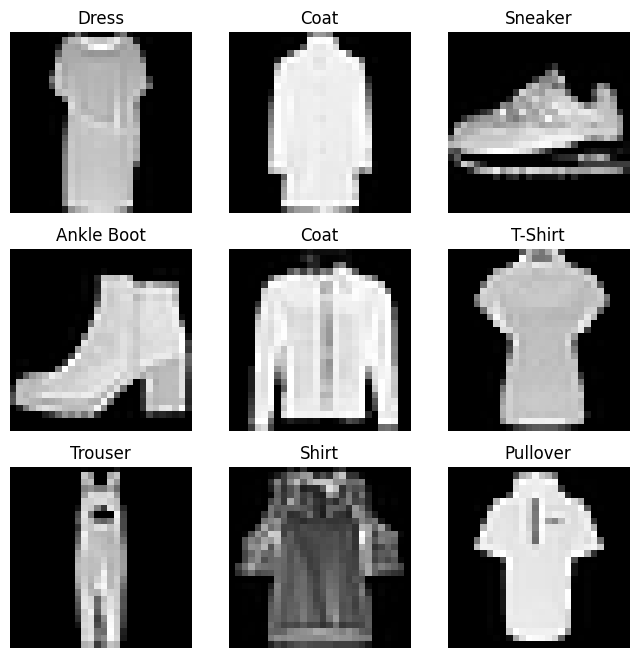

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # Genero un tensore casuale composto da un solo elemento nel range della lunghezza del data set
    # e lo converto in numero usando il metodo Tensor.item()
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
# Al fine di localizzare la zona di codice su cui intervenire
# definiamo un dict che contenga tutti gli iperparametri del modello
# potremo variarli quando vorremo agendo solo qui

hyperparameters = {
    "learning_rate": 1e-3,
    "batch_size": 64,
    "epochs": 50,
    "patience": 5,
    "min_delta": 0.01,
    "momentum": 0.9,
    "nesterov": True
}

In [ ]:
# Spostiamo i dati sulla GPU
training_data.dataset.data.to(device)
val_data.dataset.data.to(device)
test_data.data.to(device)

# Creiamo i data loaders che saranno gli iteraboili che generano i batch di
# addestramento e/o test
train_dataloader = DataLoader(training_data,
                            batch_size=hyperparameters['batch_size'], # Imposta la dimensione del batch
                            shuffle=True,                             # Shuffling dei batch tra un'epoca e l'altra
                            num_workers=8,                            # Numero dei sottoprocessi di caricamento dei dati
                            prefetch_factor=12,                       # Campioni precaricati da ogni sottoprocesso
                            pin_memory=True)                          # Usa la memoria non paginata per muovere i tensori
                                                                      # da CPU a GPU
val_dataloader = DataLoader(val_data,
                            batch_size=hyperparameters['batch_size'],
                            shuffle=True,
                            num_workers=8,
                            prefetch_factor=12,
                            pin_memory=True)

test_dataloader = DataLoader(test_data,
                            batch_size=hyperparameters['batch_size'],
                            shuffle=True,
                            num_workers=8,
                            prefetch_factor=12,
                            pin_memory=True)

# semplice investigazione della shape dei tensori: usiamo il primo
# batch del test dataloader come esempio
for X, y in test_dataloader:
    print(f"Shape di X [N, C, H, W]: {X.shape}")
    print(f"Shape di y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Shape di X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape di y: torch.Size([64]) torch.int64


In [ ]:
#  Creiamo il modello
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.deep_conv_stack = nn.Sequential(
            nn.Conv2d(1, 64, 3),        # Shape: (N, 1, 28, 28)   --> (N, 64, 26, 26) a causa del kernel 3x3
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),      # Shape: (N, 64, 26, 26)  --> (N, 128, 24, 24)
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),     # Shape: (N, 128, 24, 24) --> (N, 256, 22, 22)
            nn.ReLU(),
            nn.Conv2d(256, 64, 3),      # Shape: (N, 256, 22, 22) --> (N, 64, 20, 20)
            nn.ReLU(),
            nn.AvgPool2d(2),            # Shape: (N, 256, 20, 20) --> (N, 64, 10, 10) a causa della divisione per due
            nn.Conv2d(64, 32, 3),       # Shape: (N, 64, 10, 10)  --> (N, 32, 8, 8)
            nn.ReLU(),
            nn.AvgPool2d(2),            # Shape: (N, 32, 8, 8)    --> (N, 32, 4, 4)
            nn.Flatten(),               # Shape: (N, 32, 4, 4)    --> (N, 512) il flatten moltiplica tutte le dimensioni tra loro
            nn.Linear(512, 10)          # Shape: (N, 512)         --> (N, 10) strato denso di calcolo dei logits
        )

    def forward(self, x):
        # Calcolo della rete in avanti
        logits = self.deep_conv_stack(x)                # parte profonda della rete che estrae i logits
        if self.training:
            return logits                               # restituiamo i logits durante il training perché la
                                                        # training loss calcola anche la softmax
        else:
            pred_probab = nn.LogSoftmax(dim=1)(logits)  # uscita esplicita con log-softmax per la predizione delle etichette
            return pred_probab

# Il metodo to() sposta il modello sul device selezionato
model = NeuralNetwork().to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

NeuralNetwork(
  (deep_conv_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=512, out_features=10, bias=True)
  )
)
Numbero totale dei parametri: 540778


Prima di addestrare il nostro modello è ovviamente necessario definire una funzione di loss e un ottimizzatore.

In [ ]:
train_loss_fn = nn.CrossEntropyLoss()     # Cross-Entropia multi-classe che calcola anche la Softmax dei logits
test_loss_fn = nn.NLLLoss()               # Negative log-likelihood esplicita senza LogSoftmax

optimizer = torch.optim.SGD(
                            model.parameters(),
                            lr=hyperparameters['learning_rate'],
                            momentum=hyperparameters['momentum'],
                            nesterov=hyperparameters['nesterov']
                            )

L'addestramento e il test si effettuano come dei loop sui diversi batch, in cui esplicitamente si comanda il passo di backpropagation e/o di predizione e si stabilisce quando non devono essere calcolati i gradienti.

Pytorch non implementa l'early stopping come procedura embedded nella libreria e quindi è sempre necessario implementarlo con codice proprio. Definiremo un'apposita classe ``EarlyStopping`` a questo fine:

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza


Definiremo adesso una API di addestramento e test del modello in cui due funzioni implementano, rispettivamente, un'epoca di train e test. Successivamente, definiremo un wrapper che implementa l'addestramento e test lungo un ciclo di epoche in cui si inserirà l'early stopping.

Definiremo adesso una API di addestramento e test del modello in cui due funzioni implementano, rispettivamente, un'epoca di train e test. Successivamente, definiremo un wrapper che implementa l'addestramento e test lungo un ciclo di epoche in cui si inserirà l'early stopping.

In [ ]:
def train_loop(model, dataloader, loss_fn, optimizer, device, pbar):

    num_batches = len(dataloader)
    epoch_loss = 0.0

    # Impostiamo la modalità di training del modello: è una best practice che serve per il
    # dropout e/o batch normalization
    model.train()
    for _, (X, y) in zip(pbar,dataloader):      # questa iterazione fatta così garantisce l'avanzamento della progress
                                                # bar mentre i batch vengono prelevati dal dataloader

        # Spostiamo esplicitamente i tensori sul device di computazione
        X, y = X.to(device), y.to(device)

        # Passo esplicito di addestramento
        optimizer.zero_grad()                   # azzeriamo i gradienti dell'iterata precedente

        # Calcoliamo la loss ed effettuiamo la predizione del minibatch
        logits = model(X)
        batch_loss = loss_fn(logits, y)

        epoch_loss += batch_loss.item()

        batch_loss.backward()             # step di backpropagation

        optimizer.step()                  # passo di ottimizzazione e aggiornamento dei parametri


    # Ritorniamo la loss media dell'epoca
    return epoch_loss/num_batches



def test_loop(model, dataloader, loss_fn, device):

    # Impostiamo la modalità di valutazione del modello: è una best practice che serve per il
    # dropout e/o batch normalization
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy = 0.0, 0

    # context manager che disabilita esplicitamente il calcolo dei gradienti in fase di test
    with torch.no_grad():
        for X, y in dataloader:

            # Spostiamo esplicitamente i tensori sul device di computazione
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # L'accuracy sul batch si calcola creando il tensore di dimensione pari al batch
            # per cui i massimi argomenti di ogni predizione sono uguali alla classe predetta
            # per il singolo campione, poi convertendo questo tensore di booleani in un vettore
            # binario difloat, sommando i valori 1 ed estraendo lo scalare contenuto nel tensore risultato
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy /= size            # Per quanto detto prima, l'accuracy media va calcolata sulla dimensione del data set

    return accuracy, test_loss

# Ciclo di addestramento completo con test, early stopping e scheduler del learning rate
def train_test(model,
               epochs,
               optimizer,
               device,
               train_dataloader,
               test_dataloader,
               train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_dataloader=None,       # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate


      # check sulle funzioni di loss
      if test_loss_fn == None:
            test_loss_fn = train_loss_fn

      # liste dei valori di loss e accuracy epoca per epoca per il plot
      train_loss = []
      validation_loss = []
      test_loss = []
      accuracy = []

      num_batches = len(train_dataloader)

      # Ciclo di addestramento con early stopping
      for epoch in range(1,epochs+1):

            # Progress bar
            pbar = trange(num_batches)
            pbar.set_description(desc='Epoch {:4d}'.format(epoch))

            epoch_train_loss = train_loop(model, train_dataloader, train_loss_fn, optimizer, device, pbar)
            train_loss.append(epoch_train_loss)

            # validation se è presente la callback di early stopping
            if early_stopping != None:
                  _, epoch_validate_loss = test_loop(model, val_dataloader, test_loss_fn, device)
                  validation_loss.append(epoch_validate_loss)

            # test
            epoch_accuracy, epoch_test_loss = test_loop(model, test_dataloader, test_loss_fn, device)
            test_loss.append(epoch_test_loss)
            accuracy.append(epoch_accuracy)

            val_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '

            print(f"Train loss: {epoch_train_loss:6.4f} {val_str}Test loss: {epoch_test_loss:6.4f} Accuracy: {epoch_accuracy:6.4f}")

            # early stopping
            if early_stopping != None:
                  early_stopping(epoch_validate_loss)
                  if early_stopping.early_stop:
                        break

            # scheduler dell'iperparametro
            if scheduler != None:
                  scheduler.step()

      return (train_loss, validation_loss, test_loss, accuracy)


In [ ]:
# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

# Routine di addestramento
train_loss, validation_loss, test_loss, accuracy = train_test(model,
                                                              hyperparameters['epochs'],
                                                              optimizer,
                                                              device,
                                                              train_dataloader,
                                                              test_dataloader,
                                                              train_loss_fn,
                                                              test_loss_fn,
                                                              early_stopping,
                                                              val_dataloader)

Epoch    1: 100%|██████████| 844/844 [00:23<00:00, 36.40it/s]


Train loss: 1.6218 Validation loss: 0.7542 Test loss: 0.7763 Accuracy: 0.7073


Epoch    2: 100%|██████████| 844/844 [00:15<00:00, 54.22it/s]


Train loss: 0.6806 Validation loss: 0.6109 Test loss: 0.6321 Accuracy: 0.7677


Epoch    3: 100%|██████████| 844/844 [00:15<00:00, 54.35it/s]


Train loss: 0.5815 Validation loss: 0.5429 Test loss: 0.5689 Accuracy: 0.7872


Epoch    4: 100%|██████████| 844/844 [00:15<00:00, 53.38it/s]


Train loss: 0.5307 Validation loss: 0.4897 Test loss: 0.5191 Accuracy: 0.8103


Epoch    5: 100%|██████████| 844/844 [00:15<00:00, 54.56it/s]


Train loss: 0.4947 Validation loss: 0.4750 Test loss: 0.5092 Accuracy: 0.8123


Epoch    6: 100%|██████████| 844/844 [00:15<00:00, 54.78it/s]


Train loss: 0.4721 Validation loss: 0.4456 Test loss: 0.4825 Accuracy: 0.8275


Epoch    7: 100%|██████████| 844/844 [00:15<00:00, 54.83it/s]


Train loss: 0.4530 Validation loss: 0.4362 Test loss: 0.4690 Accuracy: 0.8269


Epoch    8: 100%|██████████| 844/844 [00:15<00:00, 52.88it/s]


Train loss: 0.4374 Validation loss: 0.4186 Test loss: 0.4595 Accuracy: 0.8305


Epoch    9: 100%|██████████| 844/844 [00:16<00:00, 49.88it/s]


Train loss: 0.4245 Validation loss: 0.4028 Test loss: 0.4411 Accuracy: 0.8396


Epoch   10: 100%|██████████| 844/844 [00:15<00:00, 53.30it/s]


Train loss: 0.4140 Validation loss: 0.3936 Test loss: 0.4355 Accuracy: 0.8475


Epoch   11: 100%|██████████| 844/844 [00:16<00:00, 52.05it/s]


Train loss: 0.4044 Validation loss: 0.3896 Test loss: 0.4277 Accuracy: 0.8491


Epoch   12: 100%|██████████| 844/844 [00:15<00:00, 53.30it/s]


Train loss: 0.3969 Validation loss: 0.3817 Test loss: 0.4175 Accuracy: 0.8509


Epoch   13: 100%|██████████| 844/844 [00:15<00:00, 53.84it/s]


Train loss: 0.3887 Validation loss: 0.3838 Test loss: 0.4228 Accuracy: 0.8466


Epoch   14: 100%|██████████| 844/844 [00:15<00:00, 53.72it/s]


Train loss: 0.3822 Validation loss: 0.3697 Test loss: 0.4050 Accuracy: 0.8548


Epoch   15: 100%|██████████| 844/844 [00:15<00:00, 53.89it/s]


Train loss: 0.3751 Validation loss: 0.3673 Test loss: 0.4001 Accuracy: 0.8559


Epoch   16: 100%|██████████| 844/844 [00:15<00:00, 52.82it/s]


Train loss: 0.3713 Validation loss: 0.3583 Test loss: 0.3946 Accuracy: 0.8565


Epoch   17: 100%|██████████| 844/844 [00:15<00:00, 53.57it/s]


Train loss: 0.3632 Validation loss: 0.3590 Test loss: 0.3954 Accuracy: 0.8599


Epoch   18: 100%|██████████| 844/844 [00:15<00:00, 53.59it/s]


Train loss: 0.3573 Validation loss: 0.3501 Test loss: 0.3803 Accuracy: 0.8614


Epoch   19: 100%|██████████| 844/844 [00:16<00:00, 52.12it/s]


Train loss: 0.3537 Validation loss: 0.3459 Test loss: 0.3838 Accuracy: 0.8649


Epoch   20: 100%|██████████| 844/844 [00:15<00:00, 53.06it/s]


Train loss: 0.3470 Validation loss: 0.3414 Test loss: 0.3778 Accuracy: 0.8646


Epoch   21: 100%|██████████| 844/844 [00:15<00:00, 53.65it/s]


Train loss: 0.3420 Validation loss: 0.3455 Test loss: 0.3775 Accuracy: 0.8616


Epoch   22: 100%|██████████| 844/844 [00:15<00:00, 53.49it/s]


Train loss: 0.3376 Validation loss: 0.3379 Test loss: 0.3671 Accuracy: 0.8685


Epoch   23: 100%|██████████| 844/844 [00:15<00:00, 53.06it/s]


Train loss: 0.3340 Validation loss: 0.3307 Test loss: 0.3648 Accuracy: 0.8659


Epoch   24: 100%|██████████| 844/844 [00:16<00:00, 51.11it/s]


Train loss: 0.3280 Validation loss: 0.3184 Test loss: 0.3560 Accuracy: 0.8726


Epoch   25: 100%|██████████| 844/844 [00:15<00:00, 52.91it/s]


Train loss: 0.3236 Validation loss: 0.3234 Test loss: 0.3595 Accuracy: 0.8713


Epoch   26: 100%|██████████| 844/844 [00:17<00:00, 49.46it/s]


Train loss: 0.3197 Validation loss: 0.3164 Test loss: 0.3501 Accuracy: 0.8751


Epoch   27: 100%|██████████| 844/844 [00:15<00:00, 52.85it/s]


Train loss: 0.3159 Validation loss: 0.3232 Test loss: 0.3586 Accuracy: 0.8744


Epoch   28: 100%|██████████| 844/844 [00:15<00:00, 53.06it/s]


Train loss: 0.3133 Validation loss: 0.3226 Test loss: 0.3577 Accuracy: 0.8713


Epoch   29: 100%|██████████| 844/844 [00:16<00:00, 51.28it/s]


Train loss: 0.3096 Validation loss: 0.3113 Test loss: 0.3407 Accuracy: 0.8773


Mostriamo gli esiti dell'addestramento

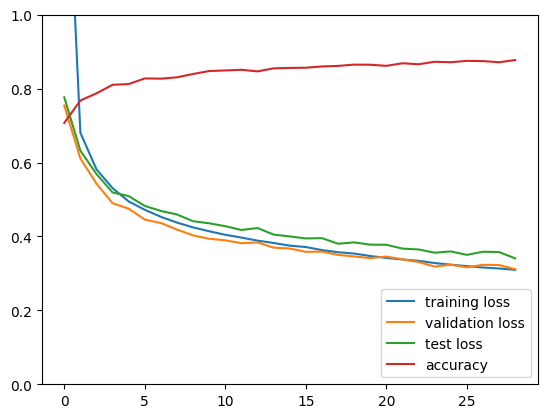

In [ ]:
plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.plot(accuracy, label='accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

## Salvataggio e caricamento del modello

Come già sappiamo, quando l'addestramento si interrompe a causa di un early stoppping ovvero perché è necessario frazionarlo per gestire le risorse limitate della GPU, ma anche semplicemente alla sua fine naturale il modello viene salvato per poterlo successivamente ricaricare a fini di fine tuning o di predizione. Si usa chiamare questa azione _model checkpoint_.

Anche questa operazione andrà codificata creando delle semplici API basate sulle primitive di ``Torch`` denominate ``torch.save()`` e ``torch.load()`` le quali salvano un qualunque ``dict`` in forma serializzata utilizzando il modulo nativo ``Python`` denominato ``pickle``.

Creeremo due semplici wrapper per le operazioni di salvataggio e caricamento del model checkpoint.

In [ ]:
def save_model(net, optimizer, current_epoch, train_loss, val_loss, test_loss, accuracy, path):

    # Abbiamo deciso per queste informazioni, ma possiamo caricare qualunque cosa
    torch.save({
            'epoch': current_epoch,
            'model_state_dict': net.state_dict(),               # configurazione di tutti i layer *addestrabili* del modello
            'optimizer_state_dict': optimizer.state_dict(),     # configurazione e operparametri dell'ottimizzatore
            'training_loss': train_loss,
            'validation_loss': val_loss,
            'test_loss': test_loss,
            'accuracy': accuracy,
            }, path)


def load_model(path, ModelClass=nn.Module, OptimizerClass=torch.optim.Optimizer, device = None):

    # Ricarichiamo il dizionario e restituiamo la tupla delle informazioni
    # La rete e l'ottimizzatore devono essere inizializzate prima di caricare
    # lo stato salvato

    # Inizializziamo il modello con la classe di rete neurale richiesta
    model = ModelClass()

    # Se il device è specificato e non è la CPU, allora muoviamo il modello sul device
    if device != None and device != 'cpu':
        model.to(device)

    # Analogo discorso per l'ottimizzatore
    optimizer = OptimizerClass(model.parameters(), lr=0.001, momentum=0.9)

    # carichiamo il model checkpoint
    checkpoint = torch.load(path)

    # inizializziamo lo stato del modello e dell'ottimizzatore
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # restituiamo tutte le informazioni in una tupla
    return (model,
            optimizer,
            checkpoint['epoch'],
            checkpoint['training_loss'],
            checkpoint['validation_loss'],
            checkpoint['test_loss'],
            checkpoint['accuracy'])


Adesso, utiliziamo le nostre API.

In [ ]:
save_model(model,
           optimizer,
           len(train_loss),
           train_loss,
           validation_loss,
           test_loss,
           accuracy,
           os.path.join(model_path,'first_nn_torch.pth'))

(mod, opt, ep, tr_loss, val_loss, testloss, acc) = load_model(os.path.join(model_path,'first_nn_torch.pth'),
                                                              NeuralNetwork,
                                                              torch.optim.SGD,
                                                              device=device)

In [ ]:
# Vogliamo riaddestrare il modello dopo l'early stopping, per cui
# inseriamo uno scheduler che faccia decrescere il learning rate ad ogni epoca
# come ulteriore regolarizzazione
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

# Usiamo lo scheduler al posto dell'ottimizzatore nell'addestramento
train_loss, _, test_loss, accuracy = train_test(mod, 10, opt, device, train_dataloader, test_dataloader,
                                                              train_loss_fn, test_loss_fn, scheduler=scheduler)

Epoch    1: 100%|██████████| 844/844 [00:17<00:00, 48.03it/s]


Train loss: 0.3057  Test loss: 0.3515 Accuracy: 0.8704


Epoch    2: 100%|██████████| 844/844 [00:16<00:00, 51.77it/s]


Train loss: 0.3000  Test loss: 0.3306 Accuracy: 0.8781


Epoch    3: 100%|██████████| 844/844 [00:15<00:00, 52.93it/s]


Train loss: 0.2969  Test loss: 0.3315 Accuracy: 0.8793


Epoch    4: 100%|██████████| 844/844 [00:17<00:00, 49.55it/s]


Train loss: 0.2925  Test loss: 0.3340 Accuracy: 0.8795


Epoch    5: 100%|██████████| 844/844 [00:16<00:00, 52.66it/s]


Train loss: 0.2887  Test loss: 0.3238 Accuracy: 0.8834


Epoch    6: 100%|██████████| 844/844 [00:15<00:00, 53.06it/s]


Train loss: 0.2859  Test loss: 0.3285 Accuracy: 0.8827


Epoch    7: 100%|██████████| 844/844 [00:15<00:00, 52.87it/s]


Train loss: 0.2825  Test loss: 0.3139 Accuracy: 0.8855


Epoch    8: 100%|██████████| 844/844 [00:15<00:00, 52.99it/s]


Train loss: 0.2799  Test loss: 0.3211 Accuracy: 0.8810


Epoch    9: 100%|██████████| 844/844 [00:16<00:00, 50.84it/s]


Train loss: 0.2776  Test loss: 0.3201 Accuracy: 0.8835


Epoch   10: 100%|██████████| 844/844 [00:15<00:00, 52.88it/s]


Train loss: 0.2754  Test loss: 0.3201 Accuracy: 0.8849


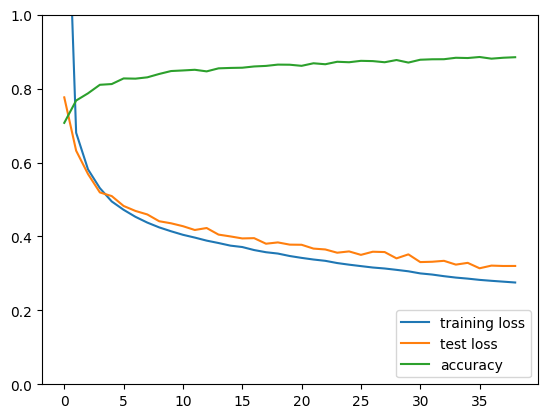

In [ ]:
# concateniamo le liste delle metriche relative ai due addestramenti e facciamo il plot
tr_loss.extend(train_loss)
testloss.extend(test_loss)
acc.extend(accuracy)

plt.plot(tr_loss, label='training loss')
plt.plot(testloss, label='test loss')
plt.plot(acc, label='accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()